[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/planetlabs/notebooks/blob/master/jupyter-notebooks/workflows/analysis_ready_data/3_ard_use_case_1_visualize_images.ipynb)

# Analysis Ready Data Tutorial Part 2: Use Case 1
## Visualize Images

In [ard_2_use_case_1.ipynb](ard_2_use_case_1.ipynb), we found scenes that match a certain search date and AOI, grouped them by dates, and for each date, we submitted an order that calculated NDVI, clipped the scenes to the AOI, and composited them into one image. In that notebook, we used QGIS to visualize the result. In this notebook, we will visualize the NDVI image with a colormap that makes it easier to understand and we will also mask out any unusable pixels identified in the [UDM2](https://www.planet.com/pulse/planets-new-usable-data-masks/). For reference, UDM2s are Usable Data Masks that use machine learning image segmentation techniques to identify which pixels in the image are clear or cloudy, or are contaminated by light or heavy haze, or snow. The resulting image mask layers, packaged as a GeoTIFF, helps visualize what parts of the image contain these elements and what parts are clear.

As mentioned in that notebook, NDVI values range from -1 to 1. Values closer to 1 represent dense, growing vegetation and values closer to 0 represent little to no vegetation.

In this notebook we do a few things to save on memory. If we didn't, the kernel would crash after displaying one or two images. First, we convert the NDVI values from float32 to uint16. This could make a difference in an analytic calculation (although it is wise to keep in mind that NDVI is *normalized*), but our eyes won't be able to tell the difference. Also, we downsample the pixels by just skipping a pixel or two (or 4 or 8...) in each direction. This is pretty blunt-force downsampling, but we don't really need anything fancy for visualization.

#### Import Dependencies

In [1]:
from itertools import chain
import json
import os
from pathlib import Path

import numpy as np
import rasterio
from zipfile import ZipFile
from visual import show_ndvi

#### Step 1: Locate order folders

In [2]:
# You should fill these in with orders you downloaded in the previous notebook.
# Order IDs will not be the same.
# You can add as many orders as you wish.
order_folders = [
    'data/use_case_1/6d00095c-474b-4c69-8024-bc21a5241c25',
    'data/use_case_1/b9ddd81d-0539-435b-b635-6bed947ef2ee'
]

print(order_folders)

['data/use_case_1/6d00095c-474b-4c69-8024-bc21a5241c25', 'data/use_case_1/b9ddd81d-0539-435b-b635-6bed947ef2ee']


In [3]:
def get_download_locations(download_dir):
    """
    Get download locations of files specified in a manifest.

    Args:
        download_dir (str): The directory path where the files are located.

    Returns:
        list: A list of file paths corresponding to the files specified in the manifest.

    Raises:
        FileNotFoundError: If the manifest file is not found.
        json.JSONDecodeError: If the manifest file cannot be parsed as JSON.
    """
    manifest_file = os.path.join(download_dir, 'manifest.json')
    with open(manifest_file, 'r') as src:
        manifest = json.load(src)

    locations = [os.path.join(download_dir, f['path'])
                 for f in manifest['files']]
    return locations


locations = []
for i in order_folders:
    location = get_download_locations(i)
    locations.append(location)

In [4]:
print("Order 1:     ", order_folders[0], "\n", locations[0])
print("Order 2:     ", order_folders[1], "\n", locations[1])


Order 1:      data/use_case_1/6d00095c-474b-4c69-8024-bc21a5241c25 
 ['data/use_case_1/6d00095c-474b-4c69-8024-bc21a5241c25/20190420_163153_0e19_metadata.json', 'data/use_case_1/6d00095c-474b-4c69-8024-bc21a5241c25/20190420_163148_0e19_3B_AnalyticMS_metadata_clip.xml', 'data/use_case_1/6d00095c-474b-4c69-8024-bc21a5241c25/20190420_164136_1002_3B_AnalyticMS_metadata_clip.xml', 'data/use_case_1/6d00095c-474b-4c69-8024-bc21a5241c25/20190420_164135_1002_3B_AnalyticMS_metadata_clip.xml', 'data/use_case_1/6d00095c-474b-4c69-8024-bc21a5241c25/20190420_164133_1002_3B_AnalyticMS_metadata_clip.xml', 'data/use_case_1/6d00095c-474b-4c69-8024-bc21a5241c25/20190420_163152_0e19_metadata.json', 'data/use_case_1/6d00095c-474b-4c69-8024-bc21a5241c25/20190420_163150_0e19_3B_AnalyticMS_metadata_clip.xml', 'data/use_case_1/6d00095c-474b-4c69-8024-bc21a5241c25/composite.tif', 'data/use_case_1/6d00095c-474b-4c69-8024-bc21a5241c25/20190420_164135_1002_metadata.json', 'data/use_case_1/6d00095c-474b-4c69-8024-b

#### Step 2: Visualize Images

In this section we will find the image files and their associated UDMs and we will visualize them.

The first band of the UDM2 file is the clear/not-clear band. 0: not-clear, 1: clear.

In [5]:
"""
These functions are a little different than what was introduced in the best practices tutorial.
First, we have to change our search a little bit to find the composite image.
Second, we convert the NDVI image to int16 to save some memory storage.
"""

def get_composite_image_and_udm_files(files):
    """
    Finds the paths for composite image file ('composite.tif') and UDM file ('composite_udm2.tif') 
    within the given list of files.

    Args:
        files (list): List of file paths.

    Returns:
        tuple: A tuple containing the paths of the composite image file and the UDM file.
               If the composite image file is not found, the path will be None.
    """
    def find_file(files, filename):
        return next((f for f in files if os.path.basename(f) == filename),
                    None)
    imgfile = find_file(files, 'composite.tif')

    if imgfile:
        udmfile = find_file(files, 'composite_udm2.tif')
    else:
        udmfile = None

    return str(imgfile), str(udmfile)


def read_ndvi_as_int(img_filename, not_clear):
    """
    Reads the NDVI band from an image file and converts it to int16 data type for memory optimization.

    Args:
        img_filename (str): File path of the image file.
        not_clear (ndarray): Boolean mask indicating clear/not clear pixels.

    Returns:
        ndarray: NDVI band as int16.
    """
    with rasterio.open(img_filename) as img:
        # NDVI is a single-band image
        ndvi = img.read(1)

        # Scale to int16
        new_dtype = np.int16
        new_max_value = np.iinfo(new_dtype).max
        new_ndvi = (ndvi * new_max_value).astype(new_dtype)
    return new_ndvi

In [6]:
# This functionality was introduced in the best practices tutorial

def unzip(filename):
    """
    Extracts a zip file to a directory with the same name as the zip file (excluding the extension).

    Args:
        filename (str): The path to the zip file.

    Returns:
        Path: The directory path where the files were extracted.
    """
    location = Path(filename)

    zipdir = location.parent / location.stem
    with ZipFile(location) as myzip:
        myzip.extractall(zipdir)
    return zipdir


def get_unzipped_files(zipdir):
    """
    Retrieves a list of file paths within a directory.

    Args:
        zipdir (Path): The directory path.

    Returns:
        list: A list of file paths.
    """
    filedir = zipdir / 'files'
    filenames = os.listdir(filedir)
    return [filedir / f for f in filenames]


def get_image_and_udm_files(file_paths):
    """
    Retrieves image files and their associated UDM files from a list of file paths.

    Args:
        file_paths (list): A list of file paths.

    Returns:
        tuple: A tuple containing two lists: image file paths and UDM file paths.
    """
    files = [str(p) for p in file_paths]

    # The image files are tiffs and are identified with '_SR_' in the name
    img_id = '_AnalyticMS_SR_'
    imgfiles = [f for f in files
                if f.endswith('.tif') and img_id in f]

    # Get associated UDM files for image files
    # Each image has a unique id at the beginning of the name
    imgroots = [str(f).split(img_id)[0] for f in imgfiles]

    # The UDM files are identified with '_UDM2' in the name
    udmfiles = [next(f for f in files if f.startswith(r + '_udm2'))
                for r in imgroots]

    return imgfiles, udmfiles


# Read UDM2 file
def read_notclear(udm2_filename):
    """
    Reads the 'not clear' band from a UDM2 file.

    Args:
        udm2_filename (str): The path to the UDM2 file.

    Returns:
        numpy.ndarray: A boolean mask indicating the 'not clear' areas.
    """
    with rasterio.open(udm2_filename) as img:
        # The first band is the clear/not clear band
        mask = img.read(1)
        not_clear = mask == 0
        return not_clear

# There is an issue where some UDMs aren't the same size as the images
# To deal with this just cut off any trailing rows/columns
# This isn't ideal as it can result in up to one pixel shift in x or y direction
def crop(img, shape):
    """
    Crop an image to a specified shape.

    Args:
        img (numpy.ndarray): The input image.
        shape (tuple): The desired shape for cropping.

    Returns:
        numpy.ndarray: The cropped image.
    """
    return img[:shape[0], :shape[1]]


def crop_and_mask(img, not_clear):
    """
    Crop an image and a mask to the same size.

    Args:
        img (numpy.ndarray): The input image.
        not_clear (numpy.ndarray): The mask indicating 'not clear' areas.

    Returns:
        numpy.ma.array: A masked array representing the cropped image and mask.
    """
    img_shape = min(img.shape, not_clear.shape)
    return np.ma.array(crop(img, img_shape),
                       mask=crop(not_clear, img_shape))

def downsample_img(img, amt=2):
    """
    Downsample an image by a specified amount.

    Args:
        img (numpy.ndarray): The input image.
        amt (int): The downsampling factor.

    Returns:
        numpy.ndarray: The downsampled image.
    """
    return img[::amt, ::amt]

#### Print the NDVI image
Now, we will retrieve the paths for a composite image file and a UDM file, print the paths, and then processes the composite image by converting the NDVI band to int16 and applying cropping, masking, and downsampling operations before displaying the resulting image.

imgfile:  data/use_case_1/6d00095c-474b-4c69-8024-bc21a5241c25/composite.tif
udmfile:  data/use_case_1/6d00095c-474b-4c69-8024-bc21a5241c25/composite_udm2.tif


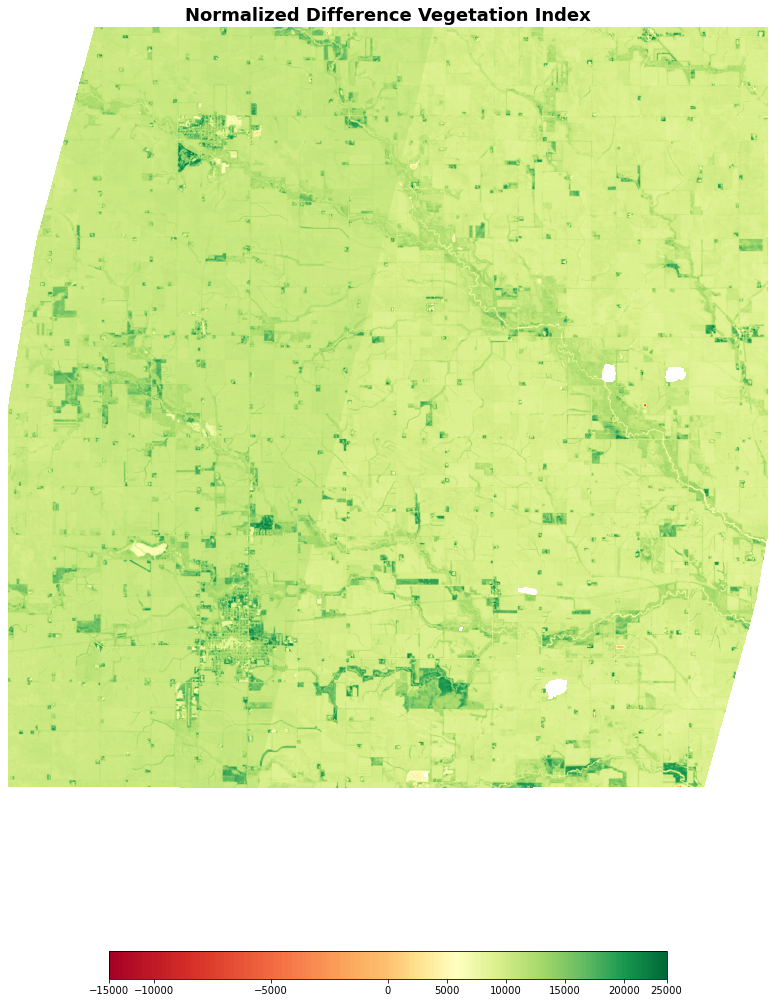

imgfile:  data/use_case_1/b9ddd81d-0539-435b-b635-6bed947ef2ee/composite.tif
udmfile:  data/use_case_1/b9ddd81d-0539-435b-b635-6bed947ef2ee/composite_udm2.tif


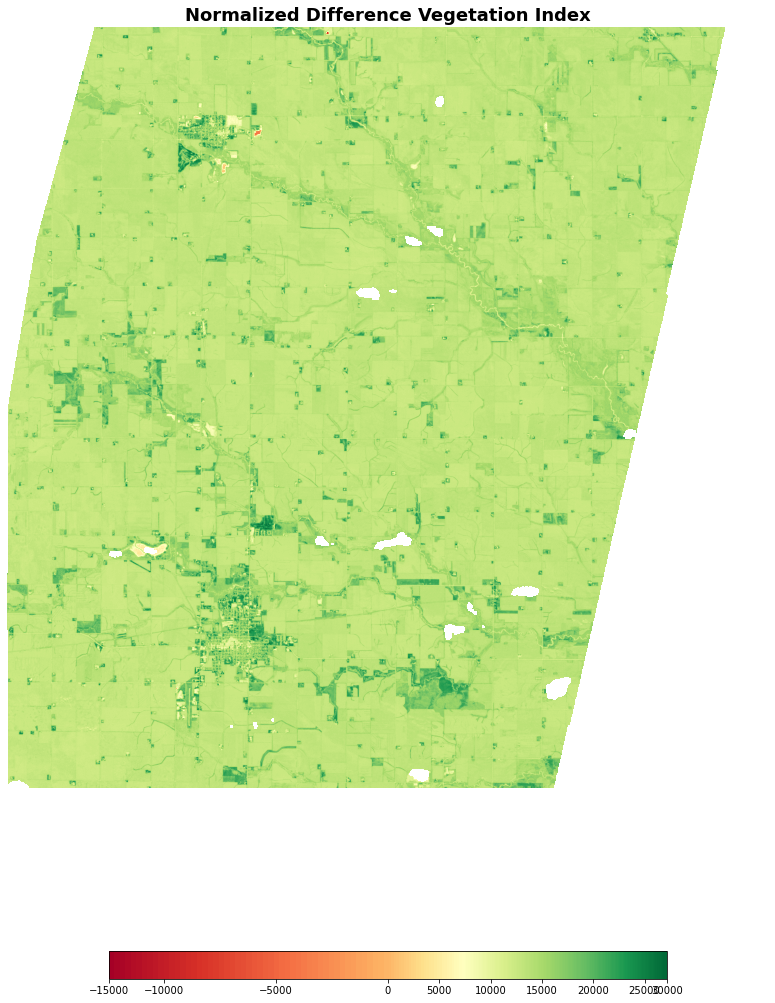

In [7]:
for location in locations:
   # Get paths for composite image file and UDM file
    imgfile, udmfile = get_composite_image_and_udm_files(location)
    print("imgfile: ", imgfile)
    print("udmfile: ", udmfile)

    # Read the NDVI band as int16 from the image file
    ndvi = read_ndvi_as_int(imgfile, udmfile)

    # Read the not-clear mask
    not_clear = read_notclear(udmfile)

    # Downsample the NDVI image, crop it based on the not-clear mask, and apply the mask
    # Then, display the result
    show_ndvi(downsample_img(crop_and_mask(ndvi, not_clear), 4), figsize=(20, 20))

Okay, we got some beautiful NDVI images down! Note the UDM2 masking of pixels outside of the footprint and the occasional errant cloud or two.